<a href="https://colab.research.google.com/github/SewoongLee/addition_TF/blob/main/addition_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
input = '1'+'2'

In [2]:
T = len(input)

In [3]:
base = 5
vocabs = [str(i) for i in range(base)]

stoi = {s: i for i, s in enumerate(vocabs)}
itos = {i: s for i, s in enumerate(vocabs)}

stoi

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

In [4]:
import numpy as np
y = np.cos(2 * np.pi * np.arange(base*2) / base)

W_emb = np.zeros((base, base))
for row in range(base):
    for col in range(base):
        W_emb[row, col] = y[base+row-col]

assert W_emb.shape[0] == len(vocabs)
emb_dim = W_emb.shape[1]
W_emb

array([[ 1.        ,  0.30901699, -0.80901699, -0.80901699,  0.30901699],
       [ 0.30901699,  1.        ,  0.30901699, -0.80901699, -0.80901699],
       [-0.80901699,  0.30901699,  1.        ,  0.30901699, -0.80901699],
       [-0.80901699, -0.80901699,  0.30901699,  1.        ,  0.30901699],
       [ 0.30901699, -0.80901699, -0.80901699,  0.30901699,  1.        ]])

Text(77.92222222222227, 0.5, 'Vocab Size')

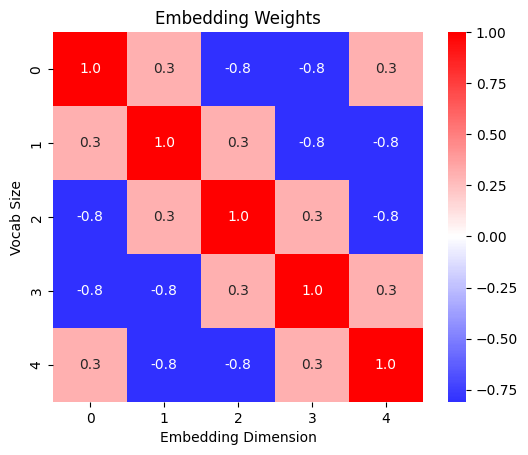

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(W_emb, annot=True, cmap='bwr', square=True, center=0, fmt='.1f')
plt.title('Embedding Weights')
plt.xlabel('Embedding Dimension')
plt.ylabel('Vocab Size')

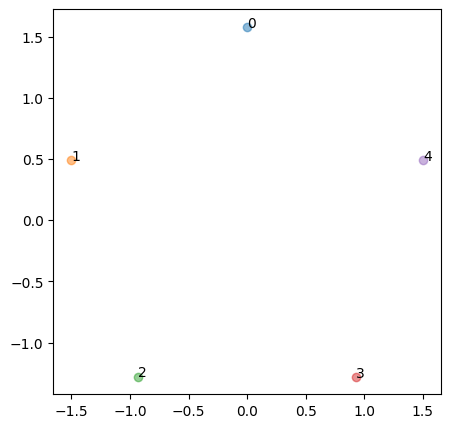

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
pca_data = pca.fit_transform(W_emb)

plt.figure(figsize=(5, 5))
for i, d in enumerate(pca_data):
    plt.scatter(d[0], d[1], alpha=0.5)
    plt.text(d[0], d[1], i)

In [7]:
x = np.array([W_emb[stoi[token]] for token in input])
x

array([[ 0.30901699,  1.        ,  0.30901699, -0.80901699, -0.80901699],
       [-0.80901699,  0.30901699,  1.        ,  0.30901699, -0.80901699]])

In [8]:
head_count = 1
d_head = emb_dim
d_model = d_head * head_count
d_model

5

In [9]:
W_Q = np.zeros((emb_dim, d_model))
W_K = np.zeros((emb_dim, d_model))
W_V = np.array([[-1.,  1.,  0.,  1., -1.],
                [ 0.,  1., -1.,  1.,  1.],
                [ 1., -1., -1.,  1.,  1.],
                [ 1., -1.,  1., -1.,  1.],
                [-1.,  0.,  1., -1., -1.]])

Q = x @ W_Q
K = x @ W_K
V = x @ W_V

assert Q.shape == (T, d_model)
assert K.shape == (T, d_model)
assert V.shape == (T, d_model)

In [10]:
import torch
M = torch.triu(torch.ones(T, T) * float('-inf'), diagonal=1)
M = M.masked_fill(torch.isnan(M), 0).numpy()
M


array([[  0., -inf],
       [  0.,   0.]], dtype=float32)

In [11]:
QK = (Q @ K.T) / np.sqrt(d_model)
weights = torch.softmax(torch.from_numpy(QK+M), dim=-1)
weights

tensor([[1.0000, 0.0000],
        [0.5000, 0.5000]], dtype=torch.float64)

In [12]:
Attention = weights @ V
Attention # Caveat: LayerNorm is not applied.

tensor([[-5.5511e-16,  1.8090e+00, -2.9271e+00,  3.2361e+00,  1.0000e+00],
        [ 1.4635e+00,  5.5511e-16, -2.3680e+00,  2.1180e+00,  2.1180e+00]],
       dtype=torch.float64)

In [13]:
ff_dim = d_model

W_1 = np.array([[ 1., -1., -1.,  0.,  1.],
                [-1.,  0.,  1.,  1., -1.],
                [ 1.,  1.,  0., -1., -1.],
                [-1., -1.,  0.,  1.,  1.],
                [ 1., -1., -1.,  0.,  1.]])
b_1 = np.zeros((ff_dim,))
print('W_1\n', W_1)
print('b_1\n', b_1)
assert W_1.shape == (d_model, ff_dim)
assert b_1.shape == (ff_dim,)

W_2 = np.array([[ 0.,  1.,  0., -1., -1.],
                [-1., -1.,  1.,  1.,  0.],
                [ 1.,  0., -1., -1.,  1.],
                [-1.,  1.,  1.,  0., -1.],
                [ 0., -1., -1.,  1.,  1.]])
b_2 = np.zeros((d_model,))
print('W_2\n', W_2)
print('b_2\n', b_2)
assert W_2.shape == (ff_dim, d_model)
assert b_2.shape == (d_model,)

FFN_X = torch.relu(torch.from_numpy(Attention.numpy() @ W_1 + b_1)) @ W_2 + b_2
assert FFN_X.shape == Attention.shape == (T, d_model)
print('FFN(X)')
print(FFN_X.round())

W_1
 [[ 1. -1. -1.  0.  1.]
 [-1.  0.  1.  1. -1.]
 [ 1.  1.  0. -1. -1.]
 [-1. -1.  0.  1.  1.]
 [ 1. -1. -1.  0.  1.]]
b_1
 [0. 0. 0. 0. 0.]
W_2
 [[ 0.  1.  0. -1. -1.]
 [-1. -1.  1.  1.  0.]
 [ 1.  0. -1. -1.  1.]
 [-1.  1.  1.  0. -1.]
 [ 0. -1. -1.  1.  1.]]
b_2
 [0. 0. 0. 0. 0.]
FFN(X)
tensor([[-7.,  3.,  2.,  5., -2.],
        [-4., -4., -4.,  8.,  4.]], dtype=torch.float64)


In [14]:
W_L = W_emb.T  # Last linear layer that converts to logits
W_L

array([[ 1.        ,  0.30901699, -0.80901699, -0.80901699,  0.30901699],
       [ 0.30901699,  1.        ,  0.30901699, -0.80901699, -0.80901699],
       [-0.80901699,  0.30901699,  1.        ,  0.30901699, -0.80901699],
       [-0.80901699, -0.80901699,  0.30901699,  1.        ,  0.30901699],
       [ 0.30901699, -0.80901699, -0.80901699,  0.30901699,  1.        ]])

In [15]:
next_token_logits = (FFN_X @ W_L)[-1]
next_token_logits

tensor([ -8.1154, -15.4990,  -1.4635,  14.5945,  10.4834], dtype=torch.float64)

In [16]:
next_token = itos[torch.argmax(torch.softmax(next_token_logits, dim=-1)).item()]
next_token

'3'

In [17]:
# Result
print(f'input: {input} => next token: {next_token}')

input: 12 => next token: 3


### Test All Cases

In [18]:
def forward(input):
    x = np.array([W_emb[stoi[token]] for token in input])
    Q = x @ W_Q
    K = x @ W_K
    V = x @ W_V
    QK = (Q @ K.T) / np.sqrt(d_model)
    weights = torch.softmax(torch.from_numpy(QK+M), dim=-1)
    Attention = weights @ V
    FFN_X = torch.relu(torch.from_numpy(Attention.numpy() @ W_1 + b_1)) @ W_2 + b_2
    next_token_logits = (FFN_X @ W_L)[-1]
    next_token = itos[torch.argmax(torch.softmax(next_token_logits, dim=-1)).item()]
    return next_token

In [19]:
for a in range(base):
    for b in range(base):
        input = str(a)+str(b)
        output = forward(input)
        print(f'{input} => {output} ({(a+b)%base == stoi[output]})')

00 => 0 (True)
01 => 1 (True)
02 => 2 (True)
03 => 3 (True)
04 => 4 (True)
10 => 1 (True)
11 => 2 (True)
12 => 3 (True)
13 => 4 (True)
14 => 0 (True)
20 => 2 (True)
21 => 3 (True)
22 => 4 (True)
23 => 0 (True)
24 => 1 (True)
30 => 3 (True)
31 => 4 (True)
32 => 0 (True)
33 => 1 (True)
34 => 2 (True)
40 => 4 (True)
41 => 0 (True)
42 => 1 (True)
43 => 2 (True)
44 => 3 (True)
